In [1]:
%%time

import numpy as np
import torch
import gc
import random
import copy
from torch import nn
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
from NN_models import NN_2_256, NN_4_256, NN_8_256, NN_8_64, NN_4_128, NN_8_128, MLOptimizer
from reaction_energy_calculation import calculate_reaction_energy, stack_reactions
from prepare_data import prepare, save_chk, load_chk


def set_random_seed(seed):
    # seed everything
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(41)

CPU times: user 3.27 s, sys: 1.66 s, total: 4.93 s
Wall time: 4.91 s


In [2]:
# %%time
# data, data_train, data_test = prepare(path='data', test_size=0.2)

# %%time
# save_chk(data, data_train, data_test, path='checkpoints')

In [2]:
%%time
data, data_train, data_test = load_chk(path='checkpoints')

CPU times: user 5.17 s, sys: 5.53 s, total: 10.7 s
Wall time: 10.7 s


In [3]:
def collate_fn(data):
    data = copy.deepcopy(data)
    reactions = []
    energies = []
    for reaction, energy in data:
        energies.append(energy)
        reaction.pop("Energy", None)
        reactions.append(reaction)
    return stack_reactions(reactions), torch.tensor(energies)
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):

        self.data = data
        
    def __getitem__(self, i):
        self.data[i].pop('Database', None)
        return self.data[i], self.data[i]['Energy']
    
    def __len__(self):
        return len(self.data.keys())


train_set = Dataset(data=data_train)
train_dataloader = torch.utils.data.DataLoader(train_set, 
                                               batch_size=12,
                                               num_workers=4,
                                               pin_memory=True,
                                               shuffle=True, collate_fn=collate_fn)

test_set = Dataset(data=data_test)
test_dataloader = torch.utils.data.DataLoader(test_set, 
                                              batch_size=None,
                                              num_workers=2,
                                              pin_memory=True,
                                              shuffle=True)

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
print(device)
criterion = nn.MSELoss()
model = NN_4_256(nconstants=24, DFT='PBE').to(device)

model.load_state_dict(torch.load('model_chk/predopt/PBE_4_256.param', map_location=device))

cuda:0


<All keys matched successfully>

In [5]:
from importlib import reload
import predopt
reload(predopt)
import NN_models
reload(NN_models)

<module 'NN_models' from '/home/duzaripov/ML-parameterization-of-DFT-functionals/NN_models.py'>

In [27]:
%%time

from predopt import DatasetPredopt
train_predopt_set = DatasetPredopt(data=data, dft='PBE')
train_predopt_dataloader = torch.utils.data.DataLoader(train_predopt_set,
                                                       batch_size=None,
                                                       num_workers=0,
                                                       pin_memory=True,
                                                       shuffle=True)

CPU times: user 119 µs, sys: 91 µs, total: 210 µs
Wall time: 219 µs


In [28]:
model = MLOptimizer(num_layers=8, h_dim=32, nconstants=24, DFT='PBE').to(device)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.01)

In [30]:
from predopt import predopt

predopt(model, criterion, optimizer, train_predopt_dataloader, device, n_epochs=10, accum_iter=10)

Epoch 1


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.88348691
train MAE Loss = 0.36357108
Epoch 2


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.04141251
train MAE Loss = 0.10595158
Epoch 3


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.01540530
train MAE Loss = 0.06127420
Epoch 4


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.01093721
train MAE Loss = 0.04964571
Epoch 5


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.00844412
train MAE Loss = 0.04286441
Epoch 6


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.00647838
train MAE Loss = 0.03713153
Epoch 7


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.00518694
train MAE Loss = 0.03272456
Epoch 8


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.00437454
train MAE Loss = 0.02955070
Epoch 9


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.00376382
train MAE Loss = 0.02694870
Epoch 10


  0%|          | 0/267 [00:00<?, ?it/s]

train MSE Loss = 0.00328967
train MAE Loss = 0.02471038


([0.8834869117939963,
  0.04141251333685738,
  0.01540529617188631,
  0.01093721306230524,
  0.008444116475262891,
  0.006478381675427382,
  0.005186942687226731,
  0.004374544633716373,
  0.003763818048195362,
  0.0032896677303312816],
 [0.36357108,
  0.10595158,
  0.061274197,
  0.049645707,
  0.042864412,
  0.037131533,
  0.032724556,
  0.029550696,
  0.026948703,
  0.024710376])

2 cpus
0 workers = 0:59
0 workers = 0:58
0 workers = 0:58
0 workers = 0:58
1 worker  = 1:03
1 worker  = 1:04
2 workers = 1:03
2 workers = 1:03
2 workers = 1:05
4 cpus
0 workers = 1:05
0 workers = 0:59
0 workers = 0:55
0 workers = 0:55
1 worker  = 1:00
1 worker  = 1:07
1 worker  = 1:07
2 workers = 1:07
2 workers = 1:07
4 workers = 1:08
4 workers = 1:08

0 workers = 1:04
1:03
1:03
1:03

In [31]:
#torch.save(model.state_dict(), 'model_chk/predopt/PBE_8_32.param')

In [12]:
# !cp model_chk/predopt/PBE_4_256.param model_chk/predopt/PBE_4_256.param_backup3

In [6]:
torch.cuda.empty_cache()

In [7]:
from tqdm.notebook import tqdm
import os

log_file_path = 'log/epoch_training.log'

if os.path.isfile(log_file_path):
    os.remove(log_file_path)

mae = torch.nn.L1Loss()

In [8]:
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs=20, accum_iter=4, verbose=False):
    train_loss_mae = []
    train_loss_mse = []
    test_loss_mae = []
    test_loss_mse = []

    for epoch in range(n_epochs):
        torch.autograd.set_detect_anomaly(True)
        print(f'Epoch {epoch+1}')
        # train
        model.train()
        progress_bar_train = tqdm(train_loader)
        train_mae_losses_per_epoch = []
        train_mse_losses_per_epoch = []
        optimizer.zero_grad()
        for batch_idx, (X_batch, y_batch) in enumerate(progress_bar_train):
            # print(f'batch_idx = {batch_idx}')
            X_batch_grid, y_batch = X_batch['Grid'].to(device), y_batch.to(device)
            predictions = model(X_batch_grid)
            reaction_energy = calculate_reaction_energy(X_batch, predictions, device, rung='GGA', dft='PBE').to(device)

            if verbose:
                print(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f}")
            loss = criterion(reaction_energy, y_batch)
            MSE = loss.item()
            MAE = mae(reaction_energy, y_batch).item()
            train_mse_losses_per_epoch.append(MSE)
            train_mae_losses_per_epoch.append(MAE)
            progress_bar_train.set_postfix(MSE = MSE, MAE = MAE)
            
 #           with open(log_file_path, 'a') as f:
 #               f.write(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f} MSE {MSE:4f} MAE {MAE:4f}\n")
            
            # loss_accumulation
            loss = loss / accum_iter
            loss.backward()
            if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()
                
            del X_batch, X_batch_grid, y_batch, predictions, reaction_energy
            gc.collect()
            torch.cuda.empty_cache()
            # gpu_usage()
        
        train_loss_mse.append(np.mean(train_mse_losses_per_epoch))        
        train_loss_mae.append(np.mean(train_mae_losses_per_epoch))

        print(f'train MSE Loss = {train_loss_mse[epoch]:.8f} MAE Loss = {train_loss_mae[epoch]:.8f}')


        
        #test
        model.eval()
        progress_bar_test = tqdm(test_loader)
        test_mae_losses_per_epoch = []
        test_mse_losses_per_epoch = []
        with torch.no_grad():
            for X_batch, y_batch in progress_bar_test:
                X_batch_grid, y_batch = X_batch['Grid'].to(device), y_batch.to(device)
                # print(f"{X_batch['Components']}")
                predictions = model(X_batch_grid)
                reaction_energy = calculate_reaction_energy(X_batch, predictions, device, rung='GGA', dft='PBE').to(device)
                loss = criterion(reaction_energy, y_batch)
                MSE = loss.item()
                MAE = torch.abs(reaction_energy - y_batch).item()
                test_mse_losses_per_epoch.append(MSE)
                test_mae_losses_per_epoch.append(MAE)
                progress_bar_test.set_postfix(MSE = MSE, MAE = MAE)

                
#                with open(log_file_path, 'a') as f:
#                    f.write(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f} MSE {MSE:4f} MAE {MAE:4f}\n")
                del X_batch, X_batch_grid, y_batch, predictions, reaction_energy, loss, MAE, MSE
                gc.collect()
                torch.cuda.empty_cache()
                
        test_loss_mse.append(np.mean(test_mse_losses_per_epoch))
        test_loss_mae.append(np.mean(test_mae_losses_per_epoch))

        print(f'test MSE Loss = {test_loss_mse[epoch]:.8f} MAE Loss = {test_loss_mae[epoch]:.8f}')

    return train_loss_mae, test_loss_mae

In [9]:
from importlib import reload
import PBE
import reaction_energy_calculation
import utils
import NN_models
reload(NN_models)
reload(utils)
reload(reaction_energy_calculation)
reload(PBE)

<module 'PBE' from '/home/duzaripov/ML-parameterization-of-DFT-functionals/PBE.py'>

In [10]:
model = MLOptimizer(num_layers=8, h_dim=32, nconstants=24, DFT="PBE").to(device)
model.zero_grad()
model.load_state_dict(torch.load('model_chk/predopt/PBE_8_32.param', map_location=device))

<All keys matched successfully>

In [11]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-5)

In [12]:
N_EPOCHS = 25
ACCUM_ITER = 5

train_loss_mae, test_loss_mae = train(model, criterion, optimizer,
                       train_dataloader, test_dataloader,
                       n_epochs=N_EPOCHS, accum_iter=ACCUM_ITER)

Epoch 1


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 94228.53120253 MAE Loss = 113.40429666


  0%|          | 0/52 [00:00<?, ?it/s]

/opt/software/python/jupyterhub2/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


test MSE Loss = 282.55011868 MAE Loss = 10.38964137
Epoch 2


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 62652.80075412 MAE Loss = 109.60402192


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 3343.77762356 MAE Loss = 22.68166516
Epoch 3


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 72719.10191515 MAE Loss = 95.73011229


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 13797.09886338 MAE Loss = 39.44650384
Epoch 4


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 78810.52301704 MAE Loss = 116.71898142


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 28199.38683813 MAE Loss = 54.47639735
Epoch 5


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 88266.04330783 MAE Loss = 102.62155533


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 32999.28780636 MAE Loss = 58.77713132
Epoch 6


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 95963.74692112 MAE Loss = 123.07716232


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 24982.06549139 MAE Loss = 51.84925964
Epoch 7


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 122663.81180149 MAE Loss = 119.59439617


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 35692.42158753 MAE Loss = 60.04090432
Epoch 8


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 115889.60696750 MAE Loss = 106.18701903


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 21618.86734139 MAE Loss = 48.83120164
Epoch 9


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 49688.82497152 MAE Loss = 93.06146653


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 40825.70719367 MAE Loss = 64.63091115
Epoch 10


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 160505.91382514 MAE Loss = 139.45493931


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 28322.81840863 MAE Loss = 55.88375337
Epoch 11


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 87019.00396050 MAE Loss = 107.44382996


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 19318.47085635 MAE Loss = 45.64223638
Epoch 12


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 87204.28645833 MAE Loss = 112.08814695


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 19619.98348206 MAE Loss = 46.58998374
Epoch 13


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 81974.11823188 MAE Loss = 111.45605003


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 20513.60010831 MAE Loss = 47.53406196
Epoch 14


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 39368.91262987 MAE Loss = 83.27514505


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 21699.33609411 MAE Loss = 48.57985684
Epoch 15


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 81619.25640191 MAE Loss = 127.89128674


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 20989.21838160 MAE Loss = 47.64492210
Epoch 16


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 54281.22137790 MAE Loss = 93.87579250


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 19741.13544521 MAE Loss = 46.57380198
Epoch 17


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 67937.53189765 MAE Loss = 102.75760640


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 25706.41600481 MAE Loss = 52.42340805
Epoch 18


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 57235.41927083 MAE Loss = 114.65157191


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 39109.57381835 MAE Loss = 63.15962573
Epoch 19


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 18268.45517307 MAE Loss = 56.59075260


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 23983.64486226 MAE Loss = 50.52900423
Epoch 20


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 163473.18040636 MAE Loss = 151.75002925


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 23507.72789333 MAE Loss = 51.03645980
Epoch 21


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 31154.50415039 MAE Loss = 83.14389759


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 20755.17632724 MAE Loss = 47.75183684
Epoch 22


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 183839.12711419 MAE Loss = 152.81267579


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 21374.66388608 MAE Loss = 48.57906911
Epoch 23


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 644431.29029677 MAE Loss = 155.05572393


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 29705.78768596 MAE Loss = 55.51283241
Epoch 24


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 136244.89945475 MAE Loss = 131.79709477


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 23875.72652531 MAE Loss = 50.67095374
Epoch 25


  0%|          | 0/18 [00:00<?, ?it/s]

train MSE Loss = 96629.14339871 MAE Loss = 117.51503065


  0%|          | 0/52 [00:00<?, ?it/s]

test MSE Loss = 27483.15488249 MAE Loss = 55.01431818


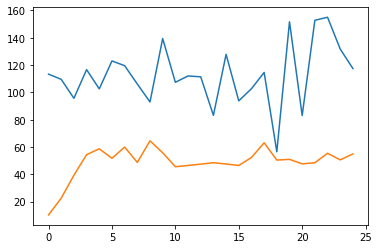

In [13]:
import matplotlib.pyplot as plt
plt.plot(np.arange(N_EPOCHS), train_loss_mae)
plt.plot(test_loss_mae)


In [ ]:
train_loss_mae

In [ ]:
def test_dft(train_loader, test_loader, c_arr, criterion, rung, dft, verbose=False, n_epochs=1, model_eval=False):
    train_loss_mae = []
    train_loss_mse = []
    test_loss_mae = []
    test_loss_mse = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}')
        # train

        progress_bar_train = tqdm(train_loader)
        train_mae_losses_per_epoch = []
        train_mse_losses_per_epoch = []
        for X_batch, y_batch in progress_bar_train:
            # print(f"{X_batch['Components']}")
            X_batch_grid, y_batch = X_batch['Grid'].to(device), y_batch.to(device)
            # print(torch.tile(c_arr, [X_batch_grid.shape[0],1]))
            if model_eval:
                predictions = model(X_batch_grid)
            else:
                predictions = torch.tile(c_arr, [X_batch_grid.shape[0],1]).to(device)
            reaction_energy = calculate_reaction_energy(X_batch, predictions, device, rung, dft)
            loss = criterion(reaction_energy, y_batch)
            MSE = loss.item()
            MAE = torch.abs(reaction_energy - y_batch).item()
            train_mse_losses_per_epoch.append(MSE)
            train_mae_losses_per_epoch.append(MAE)
            progress_bar_train.set_postfix(MSE = MSE, MAE = MAE)
            if verbose:
                print(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f} MSE {MSE:4f} MAE {MAE:4f}")

            del X_batch, X_batch_grid, y_batch, predictions, reaction_energy, loss, MAE, MSE
            gc.collect()
            torch.cuda.empty_cache()

        
        train_loss_mse.append(np.mean(train_mse_losses_per_epoch))        
        train_loss_mae.append(np.mean(train_mae_losses_per_epoch))

        print(f'train MSE Loss = {train_loss_mse[epoch]:.8f} MAE Loss = {train_loss_mae[epoch]:.8f}')


        
        #test
        progress_bar_test = tqdm(test_loader)
        test_mae_losses_per_epoch = []
        test_mse_losses_per_epoch = []
        for X_batch, y_batch in progress_bar_test:
            # print(f"{X_batch['Components']}")
            X_batch_grid, y_batch = X_batch['Grid'].to(device), y_batch.to(device)
            if model_eval:
                predictions = model(X_batch_grid)
            else:
                predictions = torch.tile(c_arr, [X_batch_grid.shape[0],1]).to(device)
            reaction_energy = calculate_reaction_energy(X_batch, predictions, device, rung, dft)
            loss = criterion(reaction_energy, y_batch)
            MSE = loss.item()
            MAE = torch.abs(reaction_energy - y_batch).item()
            # progress_bar_train.set_postfix(MAE = MAE)
            test_mse_losses_per_epoch.append(MSE)
            test_mae_losses_per_epoch.append(MAE)
            if verbose:
                print(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f} MSE {MSE:4f} MAE {MAE:4f}")
            
            del X_batch, X_batch_grid, y_batch, predictions, reaction_energy, loss, MAE, MSE
            gc.collect()
            torch.cuda.empty_cache()
                
        test_loss_mse.append(np.mean(test_mse_losses_per_epoch))
        test_loss_mae.append(np.mean(test_mae_losses_per_epoch))

        print(f'test MSE Loss = {test_loss_mse[epoch]:.8f} MAE Loss = {test_loss_mae[epoch]:.8f}')

    return train_loss_mae

In [ ]:
from importlib import reload
import NN_models
reload(NN_models)
from NN_models import NN_2_256, NN_8_256, NN_8_64
# import SVWN3

In [ ]:
from importlib import reload
import PBE
import reaction_energy_calculation
import utils
import NN_models
reload(NN_models)
reload(utils)
reload(reaction_energy_calculation)
reload(PBE)

<module 'PBE' from '/home/duzaripov/ML-parameterization-of-DFT-functionals/PBE.py'>

In [ ]:
true_constants_SVWN = torch.Tensor([0.0310907, 0.01554535, 
                3.72744,   7.06042,
                12.9352,   18.0578,
                -0.10498,  -0.32500,
                0.0310907,  0.01554535,  -1/(6*torch.pi**2),
                13.0720,    20.1231,      1.06835,
                42.7198,   101.578,      11.4813,
                -0.409286,  -0.743294,   -0.228344,
                1])

true_constants_PBE = torch.Tensor([[0.06672455,
       (1 - torch.log(torch.Tensor([2])))/(torch.pi**2),
       1.709921,
       7.5957, 14.1189, 10.357,
       3.5876, 6.1977, 3.6231,
       1.6382, 3.3662,  0.88026,
       0.49294, 0.62517, 0.49671,
       # 1,  1,  1,
       0.031091, 0.015545, 0.016887,
       0.21370,  0.20548,  0.11125,
       -3/8*(3/torch.pi)**(1/3)*4**(2/3),
       0.8040,
       0.2195149727645171]])

par_rpw92_constants = torch.Tensor([[0.06672455,
       (1 - torch.log(torch.Tensor([2])))/(torch.pi**2),
       1.709920934161365617563962776245,
       7.5957, 14.1189, 10.357,
       3.5876, 6.1977, 3.6231,
       1.6382, 4.86059,  0.88026,
       0.49294, 0.750188, 0.49671,
       # 1,  1,  1,
       0.0310907, 0.01554535, 0.0168869,
       0.21370,  0.266529,  0.11125,
       -3/8*(3/torch.pi)**(1/3)*4**(2/3),
       0.8040,
       0.2195149727645171]])


# true_constants

test_dft(train_dataloader, test_dataloader, true_constants_PBE, criterion, rung='GGA', dft='PBE', verbose=False, model_eval=True)
# test_dft(train_dataloader, test_dataloader, true_constants_SVWN, criterion, rung='LDA', dft='SVWN3', verbose=False)

# broken_PBE 45.47375717 35.76542641
# Mean Absolute Error, kcal/mol
# DFT              train        test
# SVWN3            32.63222432 26.81526929
# PBE_sigma_broken 7.84055060  7.63013082
# PBE_fixed        7.85833597  7.64929252
# PBE_pred_4_256   27.07443217 29.64430402   

Epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b93f9b1a290>
Traceback (most recent call last):
  File "/opt/software/python/jupyterhub2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/software/python/jupyterhub2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/software/python/jupyterhub2/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/software/python/jupyterhub2/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/software/python/jupyterhub2/lib/python3.10/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/opt/software/python/jupyterhub2/lib/python3.10/selectors.py", line 416, in select
    fd_event_

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [77]:
from importlib import reload
import PBE
import reaction_energy_calculation
import utils
import NN_models
reload(NN_models)
reload(utils)
reload(reaction_energy_calculation)
reload(PBE)
from reaction_energy_calculation import calculate_reaction_energy

In [78]:
from importlib import reload
import PBE
reload(PBE)
# from PBE_new import F_PBE_new

<module 'PBE' from '/home/duzaripov/ML-parameterization-of-DFT-functionals/PBE.py'>

In [100]:
res_A = torch.load('log/res_A.pt')

In [101]:
assert not torch.isnan(res_A).any()